# **Reproducing the results of the article "Graph Clustering with Graph Neural Networks"** 
##### **`Work Done By` : Aymane Masrour & Mohamed Badi**

In this notebook, we reproduce and analyze the numerical experiments from the article `Graph Clustering with Graph Neural Networks`, introducing **Deep Modularity Networks (DMoN)**, a novel method that bridges traditional modularity-based clustering with modern graph neural networks.

The experiments focus on the following **datasets**:

- Synthetic data following ADC-SBM model
- Real world data : Cora, Citeseer, Pubmed

And we compare with the following **baselines** for benchmark :

- DiffPool(graph, features), MinCutPool(graph, features).  


**To ensure clarity and completeness**, we provide a detailed description of the datasets, baselines, and corresponding implementations below.  



### **Synthetic Data Generation: ADC-SBM Model**

The **Attributed, Degree-Corrected Stochastic Block Model (ADC-SBM)** is designed to generate synthetic graphs with controllable structural and feature‐based community patterns. This model extends the classical **Stochastic Block Model (SBM)** (Snijders and Nowicki, 1997) and has been widely used to benchmark graph clustering methods (Fortunato and Hric, 2016). It has also been employed in **state-of-the-art supervised GNN experiments** (Dwivedi et al., 2023).

In our version of the model, **both graph edges and node features are generated**. The node features are produced by a **multivariate mixture model** whose cluster memberships may either align with the graph clusters or diverge from them. This flexibility enables controlled evaluation of clustering robustness.

---

### **1. Graph Generation: Degree-Corrected SBM**

We generate a random graph with $n$ nodes partitioned into $k$ clusters using a degree‐corrected SBM. In our implementation, graph edges are sampled via the **`graph-tool`** package.

#### **1.1 Block Assignments**

Nodes are assigned uniformly to $k$ clusters. Let
$$
b_i \in \{0, \dots, k-1\}
$$
denote the cluster of node $i$. In our code, we allocate approximately $n/k$ nodes per cluster and then shuffle the cluster labels to randomize node order.


In [ ]:
import os
from pathlib import Path
from typing import Optional, Tuple, Dict, List
import numpy as np
import matplotlib.pyplot as plt
import graph_tool.all as gt
import argparse

def _create_block_memberships(n: int, k: int) -> np.ndarray:
    """Create shuffled block memberships"""
    block_size = n // k
    blocks = np.repeat(np.arange(k), block_size)
    if len(blocks) < n:
        blocks = np.pad(blocks, (0, n - len(blocks)), mode='constant')
    np.random.shuffle(blocks)
    return blocks

#### **1.2 Expected Edge Count Matrix**

Define a symmetric matrix $D \in \mathbb{R}^{k \times k}$ where $D_{ij}$ represents the expected number of edges between nodes in clusters $i$ and $j$. For a graph with expected average degree $d$, we decompose this into an intra-cluster (within) part and an inter-cluster (between) part:
- **Intra-cluster degree:** 
  $$
  d_{\text{in}} = d - d_{\text{out}}
  $$
- **Inter-cluster degree:** 
  $$
  d_{\text{out}}
  $$

Using an expected block size of $n/k$, we set:
- **Undirected graphs:**
  - For nodes in the same cluster:
    $$
    D_{ii} = \frac{n}{k}\, d_{\text{in}}
    $$
    (`graph-tool` interprets the diagonal as twice the average within‐cluster edge count.)
  - For nodes in different clusters:
    $$
    D_{ij} = \frac{n}{k}\, \frac{d_{\text{out}}}{k-1}, \quad i\neq j.
    $$
- **Directed graphs:**  
  The diagonal and off-diagonal entries are set similarly but without the factor of two on the diagonal.


In [ ]:
def _create_affinity_matrix(k: int, n: int, d: int, d_out: int) -> np.ndarray:
    """Create SBM affinity matrix"""
    block_size = n / k
    d_in = d - d_out
    D = np.full((k, k), block_size * (d_out / (k - 1)))
    np.fill_diagonal(D, block_size * d_in)
    return D

#### **1.3 Degree Correction**

To mimic real-world degree heterogeneity, we assign each node a degree correction factor $\theta_i$. For each graph cluster, the $\theta_i$ values are generated from a discrete power-law (Zipf) distribution, clipped to lie within $[d_{\min}, d_{\max}]$, and then normalized so that the average $\theta$ in each cluster is 1. Edges are then generated such that the expected number of edges between nodes $i$ and $j$ is
$$
\lambda_{ij} = \theta_i\, \theta_j\, D_{b_i, b_j}.
$$
`graph-tool`’s DC-SBM generator uses these parameters to sample edges according to a Poisson process (or a Bernoulli process if a simple graph is enforced).



In [ ]:
def _generate_degree_corrections(blocks: np.ndarray, params) -> np.ndarray:
    """Generate degree correction factors using Zipf distribution"""
    theta = np.ones(len(blocks))
    for cluster in range(params.k):
        mask = (blocks == cluster)
        size = mask.sum()
        if size > 0:
            degs = np.random.zipf(params.alpha, size)
            degs = np.clip(degs, params.d_min, params.d_max)
            theta[mask] = degs / degs.mean()
    return theta

def generate_dc_sbm_graph(params) -> Tuple[gt.Graph, np.ndarray]:
    """Generate degree-corrected SBM graph with given parameters"""
    if params.seed is not None:
        np.random.seed(params.seed)
    
    # Assign shuffled block memberships
    block_membership = _create_block_memberships(params.n, params.k)
    
    # Create affinity matrix
    D = _create_affinity_matrix(params.k, params.n, params.d, params.d_out)
    
    # Generate degree corrections
    theta = _generate_degree_corrections(block_membership, params)
    
    # Create graph
    graph = gt.generate_sbm(
        b=block_membership.tolist(),
        probs=D,
        directed=params.directed,
        out_degs=theta.tolist(),
        in_degs=theta.tolist() if params.directed else None
    )
    
    if params.simple_graph:
        gt.remove_parallel_edges(graph)
        gt.remove_self_loops(graph)
        
    return graph, block_membership

The difference $d_{\text{in}} - d_{\text{out}}$ governs the spectral detectability of the clusters (Nadakuditi and Newman, 2012). Larger differences result in more pronounced community structure.


### **2. Node Feature Generation: Multivariate Mixture Model**

To study the interplay between graph structure and node features, we generate features from a multivariate mixture model. The model allows the feature cluster memberships to either **match**, **nest**, or **group** the graph clusters.

#### **2.1 Feature Cluster Assignments** *`(see 4.1 for visualization)`*

Each node $i$ is assigned a feature cluster label $z_i \in \{0, \dots, k_f-1\}$. The relationship between feature clusters and graph clusters is controlled by the parameter `feature_cluster_type`:

- **Matching:**  
  The feature clusters are identical to the graph clusters, i.e., $z_i = b_i$. In this case, $k_f = k$.

- **Nested:**  
  Each graph cluster is subdivided into several (sub-)feature clusters. Formally, if we set
  $$
  n_{\text{nested}} = \lceil k_f/k \rceil,
  $$
  To assign nodes to subclusters, the nodes in each graph cluster are randomly partitioned into $n_{\text{nested}}$ subclusters. The partitioning is done as follows:
  1. For a graph cluster with $m_i$ nodes, choose $n_{\text{nested}}-1$ random dividers from $\{1,\dots,m_i-1\}$.
  2. Sort the dividers to get $0 = d_0 < d_1 < \dots < d_{n_{\text{nested}}-1} < d_{n_{\text{nested}}} = m_i$.
  3. The size of each subcluster $s_{i,j}$ is given by:
     $$
     s_{i,j} = d_{j+1} - d_j \quad \text{for } j \in \{0,\dots,n_{\text{nested}}-1\}.
     $$
  4. Nodes in subcluster $s_{i,j}$ are assigned the feature label:
     $$
     z_p = i \cdot n_{\text{nested}} + j \quad \forall p \in s_{i,j}.
     $$

- **Grouped:**  
  Multiple graph clusters are merged into a single feature cluster. This is achieved by mapping the graph cluster labels to a smaller set:
  $$
  z_i = \left\lfloor \frac{b_i\, k_f}{k} \right\rfloor.
  $$
  Here, $k_f < k$.

- **Independent:**  
  If no specific relationship is desired, feature memberships can be assigned independently at random.

#### **2.2 Feature Distribution**

Once feature cluster assignments are determined, we generate the actual node features as follows:

1. **Feature-cluster centers:**  
   Draw $k_f$ centers $\boldsymbol\mu_0, \dots, \boldsymbol\mu_{k_f-1} \in \mathbb{R}^s$ from a multivariate normal distribution with covariance matrix $\sigma_c^2\, I_{s}$:
   $$
   \boldsymbol\mu_r \sim \mathcal{N}(\mathbf{0},\, \sigma_c^2\, I_{s}).
   $$

2. **Sampling node features:**  
   For each node $i$ with feature cluster $z_i$, sample its feature vector from a Gaussian centered at $\boldsymbol\mu_{z_i}$ with covariance $\sigma^2\, I_{s}$:
   $$
   \mathbf{x}_i \sim \mathcal{N}(\boldsymbol\mu_{z_i},\, \sigma^2\, I_{s}).
   $$
   The ratio $\sigma_c^2/\sigma^2$ controls the separation (or separability) of the feature clusters.


In [ ]:
def generate_features_from_membership(
    block_membership: np.ndarray,
    params
) -> Tuple[np.ndarray, np.ndarray]:
    """Generate node features based on block memberships"""
    if params.seed is not None:
        np.random.seed(params.seed)
    
    n = len(block_membership)
    
    feature_blocks, centers = _determine_feature_clusters(
        block_membership, 
        params.feature_cluster_type,
        params.k_f,
        params.s,
        params.sigma_c  # Pass sigma_c to cluster determination
    )
    
    # Apply nested-specific clipping from original code
    if params.feature_cluster_type == 'nested':
        feature_blocks = np.clip(feature_blocks, 0, params.k_f-1)
    
    # Generate features with cluster centers and noise
    features = centers[feature_blocks] + np.random.normal(0, params.sigma, (n, params.s))
    return feature_blocks, features

def _determine_feature_clusters(
    block_membership: np.ndarray,
    cluster_type: str,
    k_f: int,
    s: int,
    sigma_c: float  # Added sigma_c parameter
) -> Tuple[np.ndarray, np.ndarray]:
    """Determine feature cluster assignments and centers with sigma_c"""
    k = len(np.unique(block_membership))
    n = len(block_membership)
    
    if cluster_type == "matching":
        feature_blocks = block_membership.copy()
        centers = np.random.normal(0, sigma_c, (k, s))
    
    elif cluster_type == "nested":
        feature_blocks, centers = _create_nested_clusters(
            block_membership, k_f, s, sigma_c
        )
    
    elif cluster_type == "grouped":
        feature_blocks = np.floor(block_membership * k_f / k).astype(int)
        centers = np.random.normal(0, sigma_c, (k_f, s))
    
    else:  # independent
        feature_blocks = np.random.randint(0, k_f, n)
        centers = np.random.normal(0, sigma_c, (k_f, s))
    
    return feature_blocks, centers

def _create_nested_clusters(
    block_membership: np.ndarray,
    k_f: int,
    s: int,
    sigma_c: float  # Added sigma_c parameter
) -> Tuple[np.ndarray, np.ndarray]:
    """Create nested feature clusters with proper sigma_c usage"""
    k = len(np.unique(block_membership))
    n_nested = int(np.ceil(k_f / k))
    feature_blocks = np.empty_like(block_membership)
    
    # Generate centers with parameterized sigma_c
    centers = np.random.normal(0, sigma_c, (k_f, s))
    
    for cluster in np.unique(block_membership):
        cluster_indices = np.where(block_membership == cluster)[0]
        np.random.shuffle(cluster_indices)
        size = len(cluster_indices)
        
        first_sub_id = cluster * n_nested
        last_sub_id = min(first_sub_id + n_nested, k_f)
        actual_subclusters = last_sub_id - first_sub_id
        
        if actual_subclusters > 0:
            sizes = _partition_integers(size, actual_subclusters)
            start_idx = 0
            for sub_id in range(actual_subclusters):
                end_idx = start_idx + sizes[sub_id]
                feature_blocks[cluster_indices[start_idx:end_idx]] = first_sub_id + sub_id
                start_idx = end_idx
                
    return feature_blocks, centers
    
def _partition_integers(total: int, parts: int) -> List[int]:
    """Randomly partition integer into positive parts"""
    if parts <= 1:
        return [total]
    dividers = sorted(np.random.choice(range(1, total), parts-1, replace=False))
    return np.diff([0] + dividers + [total])


### **3. ADC-SBM Generation**
Below is the code for generating a complete ADC-SBM (Attributed Degree-Corrected Stochastic Block Model) dataset based on the previous functions :

In [ ]:
def generate_adc_sbm(params) -> tuple:
    """Generate complete ADC-SBM dataset"""
    graph, blocks = generate_dc_sbm_graph(params)
    feat_blocks, features = generate_features_from_membership(blocks, params)
    return graph, blocks, feat_blocks, features

### **4. Default Model Parameters and Experimental Variations**
To study **robustness and sensitivity**, we define a **default ADC-SBM model** and explore variations.

#### **4.1 Default Model Configuration**
We set:
- **Graph properties:**
  - $n = 1000$ nodes.
  - $k = 4$ graph clusters.
  - Expected degree $d = 20$.
  - Average inter-cluster degree $d_{\text{out}} = 2$.
  - Power-law exponent $\alpha = 2$, with degree limits $d_{\min} = 2$, $d_{\max} = 4$.

- **Feature properties:**
  - Feature dimension $s = 32$.
  - Feature clusters $k_f = 4$.
  - Within-cluster variance $\sigma^2 = 1$.
  - Cluster-center variance $\sigma_c^2 = 3$.

#### **4.2 Datasets Variations**
We explore six scenarios by varying key parameters:

| **Scenario** | **Parameter** | **Description** |
|-------------|--------------|----------------|
| **1** | $d_{\text{out}} \in [2.0, 5.0]$  | Varying inter-cluster connectivity. Larger $d_{\text{out}}$ weakens cluster separation. |
| **2** | $\sigma_c \in [10^{-2}, 10^{1}]$  | Increasing feature-cluster variance. Higher $\sigma_c$ means better separability. |
| **3** | $\sigma_c \in [10^{-2}, 10^{1}]$ (nested) | Feature clusters are nested within graph clusters. |
| **4** | $\sigma_c \in [10^{-2}, 10^{1}]$ (grouped) | Multiple graph clusters map to a single feature cluster. |
| **5** | $d \in [2^2, 2^7]$ | Increasing total degree, making structural clusters stronger. |
| **6** | $d_{\max} \in [2^2, 2^{10}]$   | Controlling the power-law tail to test degree effects. |

In [ ]:
class GenerationParameters:
    """Container for graph and feature generation parameters"""
    def __init__(
        self,
        n: int = 1000,
        k: int = 4,
        d: int = 20,
        d_out: int = 2,
        d_min: int = 2,
        d_max: int = 4,
        alpha: float = 2,
        s: int = 32,
        k_f: int = 4,
        sigma: float = 1,
        sigma_c: float = 3,
        directed: bool = False,
        feature_cluster_type: str = "matching",
        simple_graph=False,
        seed: Optional[int] = None
    ):
        self.n = n
        self.k = k
        self.d = d
        self.d_out = d_out
        self.d_min = d_min
        self.d_max = d_max
        self.alpha = alpha
        self.s = s
        self.k_f = k_f
        self.sigma = sigma
        self.sigma_c = sigma_c
        self.directed = directed
        self.feature_cluster_type = feature_cluster_type
        self.simple_graph = simple_graph
        self.seed = seed


# =============================================================================
# Dataset Generation
# =============================================================================
def generate_scenario_datasets(base_dir: Path = Path("adc_sbm_datasets")) -> None:
    """Generate multiple scenario datasets with varying parameters"""
    scenarios = [
        {
            "name": "dout_variation",
            "dir": "scenario_1_dout",
            "param": "d_out",
            "values": np.linspace(2.0, 5.0, 4),
            "feature_type": "matching"
        },
        # Add other scenarios similarly...
    ]

    base_params = GenerationParameters()
    
    for scenario in scenarios:
        scenario_dir = base_dir / scenario["dir"]
        scenario_dir.mkdir(parents=True, exist_ok=True)
        
        for value in scenario["values"]:
            params = GenerationParameters(
                **{scenario["param"]: value},
                feature_cluster_type=scenario["feature_type"]
            )
            
            graph, blocks, feat_blocks, features = generate_adc_sbm(params)
            dataset_name = f"{scenario['param']}_{value:.3f}".replace('.', '_')
            save_dataset(graph, blocks, feat_blocks, features, scenario_dir, dataset_name)

In [86]:
# =============================================================================
# Dataset I/O Operations
# =============================================================================
import numpy as np
from pathlib import Path

def save_dataset(
    graph,  # a graph-tool Graph object
    block_membership: np.ndarray,
    feature_blocks: np.ndarray,
    features: np.ndarray,
    output_dir: Path,
    dataset_name: str
) -> None:
    """
    Save the generated dataset to a directory in a format independent of graph-tool.
    The graph is saved as a generic dictionary containing an edge list (as integer pairs) and the number of nodes.
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Convert each graph-tool edge to a pair of integers (source, target).
    edge_list = np.array([[int(e.source()), int(e.target())] for e in graph.edges()])
    n_nodes = graph.num_vertices()
    
    # Save the graph information as a compressed npz file.
    np.savez(output_dir / f"{dataset_name}_graph.npz", edge_list=edge_list, n_nodes=n_nodes)
    
    # Save the numpy arrays for block membership, feature blocks, and features.
    np.save(output_dir / f"{dataset_name}_block_membership.npy", block_membership)
    np.save(output_dir / f"{dataset_name}_feature_blocks.npy", feature_blocks)
    np.save(output_dir / f"{dataset_name}_features.npy", features)



def load_dataset(output_dir: Path, dataset_name: str) -> tuple:
    # Load the graph information from the npz file.
    graph_file = output_dir / f"{dataset_name}_graph.npz"
    if not graph_file.exists():
        raise FileNotFoundError(f"Graph file not found: {graph_file}")
    graph_data = np.load(graph_file)
    edge_list = graph_data["edge_list"]
    n_nodes = int(graph_data["n_nodes"])
    
    # Load the other arrays.
    block_membership = np.load(output_dir / f"{dataset_name}_block_membership.npy")
    feature_blocks = np.load(output_dir / f"{dataset_name}_feature_blocks.npy")
    features = np.load(output_dir / f"{dataset_name}_features.npy")
    
    return edge_list, n_nodes, block_membership, feature_blocks, features


In [ ]:
def visualize_covariance_comparison() -> None:
    """Generate comparison plots of feature covariance structures with bold, large plot titles."""
    # Base graph generation
    params = GenerationParameters(n=300, k=4, seed=42)
    graph, blocks = generate_dc_sbm_graph(params)
    
    # Feature generation parameters
    feature_params = [
        ("Matching", GenerationParameters(feature_cluster_type="matching", k_f=4, seed=101)),
        ("Nested", GenerationParameters(feature_cluster_type="nested", k_f=6, seed=102)),
        ("Grouped", GenerationParameters(feature_cluster_type="grouped", k_f=3, seed=104)),
    ]
    
    # Calculate covariance matrices
    covariance_data = []
    for name, params in feature_params:
        feat_blocks, features = generate_features_from_membership(blocks, params)
        ordered_features = features[np.argsort(feat_blocks)]
        covariance_data.append(np.cov(ordered_features, rowvar=True))
    
    # Create visualization
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    titles = ["Graph Structure"] + [name for name, _ in feature_params]
    
    # Plot adjacency matrix (Graph Structure)
    sorted_idx = np.argsort(blocks)
    axs[0].imshow(gt.adjacency(graph).toarray()[sorted_idx][:, sorted_idx], cmap='binary')
    axs[0].set_title("Graph Structure", fontweight='bold', fontsize=16)
    
    # Plot covariance matrices with bold, larger titles
    for ax, title, data in zip(axs[1:], titles[1:], covariance_data):
        im = ax.imshow(data, cmap='viridis')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(title, fontweight='bold', fontsize=16)
    
    plt.tight_layout()
    plt.savefig("covariance.png", dpi=300)
    plt.show()


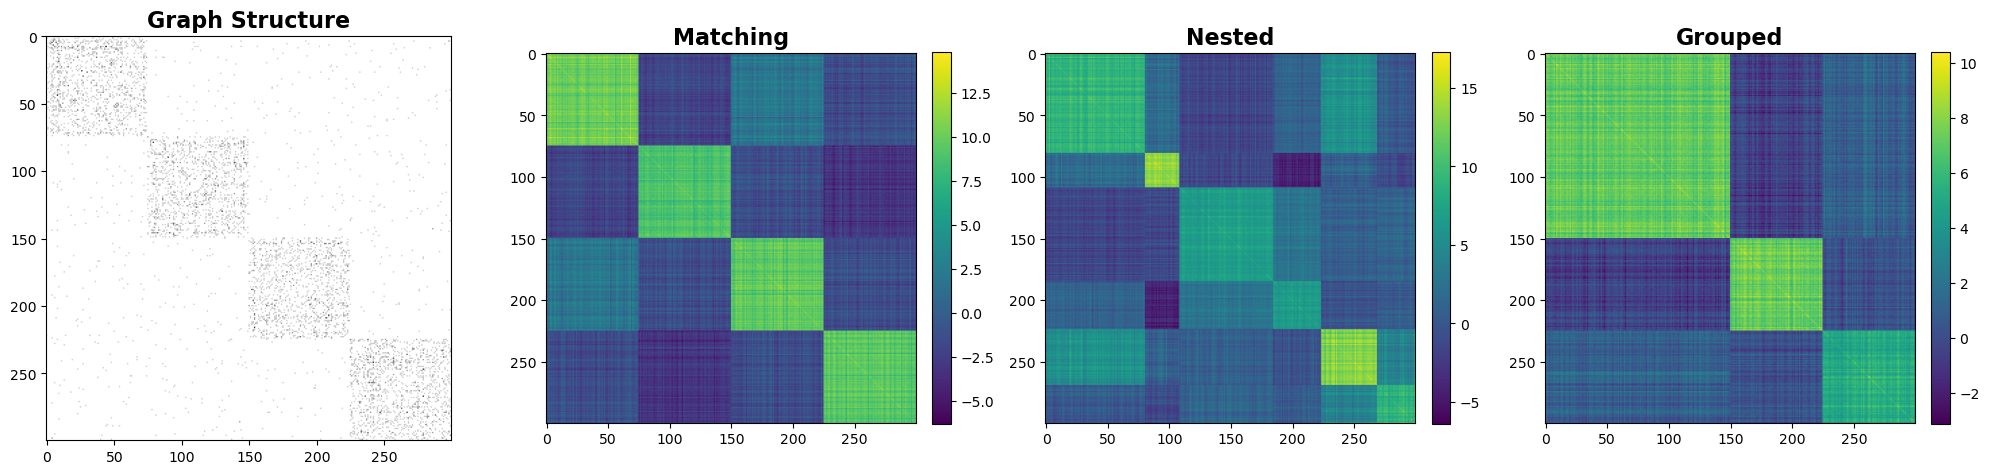

In [ ]:
visualize_covariance_comparison()

In [ ]:
def generate_scenario_datasets(base_dir: Path = Path("adc_sbm_datasets")) -> None:
    scenarios = [
        {
            "name": "dout_variation",
            "dir": "scenario_1_dout",
            "param": "d_out",
            "values": np.linspace(2.0, 5.0, 4),
            "feature_type": "matching"
        },
        {
            "name": "sigma_c_independent",
            "dir": "scenario_2_sigmac_independent",
            "param": "sigma_c",
            "values": np.logspace(-2, 1, 4),
            "feature_type": "matching"
        },
        {
            "name": "sigma_c_nested",
            "dir": "scenario_3_sigmac_nested",
            "param": "sigma_c",
            "values": np.logspace(-2, 1, 4),
            "feature_type": "nested"
        },
        {
            "name": "sigma_c_grouped",
            "dir": "scenario_4_sigmac_grouped",
            "param": "sigma_c",
            "values": np.logspace(-2, 1, 4),
            "feature_type": "grouped"
        },
        {
            "name": "degree_variation",
            "dir": "scenario_5_degree",
            "param": "d",
            "values": 2 ** np.arange(2, 8),
            "feature_type": "matching"
        },
        {
            "name": "powerlaw_tail",
            "dir": "scenario_6_dmax",
            "param": "d_max",
            "values": 2 ** np.arange(2, 11, 2),
            "feature_type": "matching"
        }
    ]

    base_params = GenerationParameters()

    print(f"[INFO] Starting dataset generation in base directory: {base_dir}")
    
    for scenario in scenarios:
        scenario_dir = base_dir / scenario["dir"]
        scenario_dir.mkdir(parents=True, exist_ok=True)
        print(f"\n[SCENARIO] {scenario['name']} ({scenario['param']})")
        print(f"→ Output directory: {scenario_dir}")

        for value in scenario["values"]:
            print(f"  - Generating for {scenario['param']} = {value:.3f} ...", end=" ", flush=True)
            custom_params = GenerationParameters(
                **{scenario["param"]: value},
                feature_cluster_type=scenario["feature_type"]
            )

            graph, blocks, feat_blocks, features = generate_adc_sbm(custom_params)
            dataset_name = f"{scenario['param']}_{value:.3f}".replace('.', '_')
            save_dataset(graph, blocks, feat_blocks, features, scenario_dir, dataset_name)
            print("")
        print("✓ Done")

    print("\n[INFO] All scenario datasets generated successfully.")


In [ ]:
generate_scenario_datasets()

[INFO] Starting dataset generation in base directory: adc_sbm_datasets

[SCENARIO] dout_variation (d_out)
→ Output directory: adc_sbm_datasets/scenario_1_dout
  - Generating for d_out = 2.000 ... 
  - Generating for d_out = 3.000 ... 
  - Generating for d_out = 4.000 ... 
  - Generating for d_out = 5.000 ... 
✓ Done

[SCENARIO] sigma_c_independent (sigma_c)
→ Output directory: adc_sbm_datasets/scenario_2_sigmac_independent
  - Generating for sigma_c = 0.010 ... 
  - Generating for sigma_c = 0.100 ... 
  - Generating for sigma_c = 1.000 ... 
  - Generating for sigma_c = 10.000 ... 
✓ Done

[SCENARIO] sigma_c_nested (sigma_c)
→ Output directory: adc_sbm_datasets/scenario_3_sigmac_nested
  - Generating for sigma_c = 0.010 ... 
  - Generating for sigma_c = 0.100 ... 
  - Generating for sigma_c = 1.000 ... 
  - Generating for sigma_c = 10.000 ... 
✓ Done

[SCENARIO] sigma_c_grouped (sigma_c)
→ Output directory: adc_sbm_datasets/scenario_4_sigmac_grouped
  - Generating for sigma_c = 0.010 ..

In [ ]:
from pathlib import Path

# Define the directory and dataset name
output_dir = Path("adc_sbm_datasets/scenario_1_dout")
dataset_name = "d_out_5_000"

# Load the dataset (note: now returns five values)
edge_list, n_nodes, block_membership, feature_blocks, features = load_dataset(output_dir, dataset_name)

# Confirm successful load
print(f"[SUCCESS] Loaded dataset: {dataset_name}")
print(f"Edge list shape: {edge_list.shape}")
print(f"Block membership shape: {block_membership.shape}")
print(f"Feature blocks shape: {feature_blocks.shape}")
print(f"Features shape: {features.shape}")

# Compute graph statistics using the edge list and node count:
N = n_nodes
E = edge_list.shape[0]
directed = False  # Assuming an undirected graph
avg_degree = (2 * E / N) if not directed else (E / N)
density = (2 * E) / (N * (N - 1)) if not directed else (E / (N * (N - 1)))

print("\n[GRAPH STATS]")
print(f"Number of nodes     : {N}")
print(f"Number of edges     : {E}")
print(f"Directed            : {directed}")
print(f"Average degree      : {avg_degree:.2f}")
print(f"Graph density       : {density:.5f}")


[SUCCESS] Loaded dataset: d_out_5_000
Edge list shape: (9990, 2)
Block membership shape: (1000,)
Feature blocks shape: (1000,)
Features shape: (1000, 32)

[GRAPH STATS]
Number of nodes     : 1000
Number of edges     : 9990
Directed            : False
Average degree      : 19.98
Graph density       : 0.02000


**Comment**: We see that the average degree is close to $d = 20$, which aligns with our target for the default model configuration. This confirms that the degree parameter was correctly applied during generation and the graph structure reflects the intended connectivity level.

## **Real-World Datasets: Cora, Citeseer, Pubmed**

We evaluate clustering performance on three citation networks: **Cora, Citeseer, and Pubmed**, which are widely used benchmarks for **graph clustering** and **node classification** tasks. These datasets combine **graph structure (edges)** with **node features (text content)** and **ground-truth class labels**, enabling evaluation of **graph clustering** and **label alignment** metrics.

### **Class Balance**
- The class distributions in these datasets tend to be **imbalanced**, with some categories having significantly fewer nodes than others.  
- **Cora** has **7 classes**, but some classes have twice as many nodes as the least represented ones.  
- **Citeseer** exhibits even stronger class imbalance, making clustering harder.  
- **Pubmed**, with only **3 classes**, is more balanced compared to the other two but has fewer intra-class edges.

### **Edge Distribution**
- Edges in these citation networks follow a **power-law distribution**, meaning:
  - Most nodes have only a few connections, while a **small number of highly connected nodes ("hubs") exist**.
  - This **heterogeneous degree distribution** can lead to biases in learning methods that assume uniform connectivity.
- In **Cora and Citeseer**, edges tend to be **more intra-class** (nodes from the same class link more frequently).  
- **Pubmed**, on the other hand, has more **inter-class connections**, making it a more challenging dataset for clustering methods that rely on connectivity patterns.


In [87]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric import transforms as T

import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import degree

def load_and_analyze_dataset(name):
    """Load dataset, preprocess, and compute statistics."""
    # Preprocessing: Convert to undirected, remove self-loops, and keep largest connected component
    transform = T.Compose([
        T.ToUndirected(),
        T.RemoveSelfLoops(),
        T.LargestConnectedComponents(num_components=1)
    ])
    
    # Load dataset
    dataset = Planetoid(root='./data', name=name, transform=transform)
    data = dataset[0]
    
    # Compute statistics
    num_nodes = data.num_nodes
    num_edges = data.edge_index.shape[1] // 2  # Undirected edges
    num_features = data.num_features
    num_classes = dataset.num_classes
    avg_degree = (2 * num_edges) / num_nodes
    
    # Feature sparsity calculation
    if data.x.is_sparse:
        x_dense = data.x.to_dense()
    else:
        x_dense = data.x
    non_zero = (x_dense > 0).sum().item()
    sparsity = (1 - (non_zero / (num_nodes * num_features))) * 100
    
    # Print results
    print(f"\n{name} Dataset Statistics:")
    print(f"Nodes (|V|): {num_nodes}")
    print(f"Edges (|E|): {num_edges}")
    print(f"Features (|X|): {num_features}")
    print(f"Classes (|Y|): {num_classes}")
    print(f"Avg. Degree: {avg_degree:.1f}")
    print(f"Feature Sparsity: {sparsity:.2f}%\n")
    return data

def plot_class_distribution(data, dataset_name="Graph Dataset"):
    # Count occurrences of each class
    unique, counts = np.unique(data.y, return_counts=True)

    # Plot class distribution
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts, color='teal')
    plt.title(f"{dataset_name} Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Nodes")
    plt.xticks(unique)
    plt.show()


def plot_degree_distribution(data, dataset_name="Graph Dataset", bins=50):
    # Compute node degrees
    degrees = degree(data.edge_index[0]).numpy()

    # Plot degree distribution (log-log scale)
    plt.figure(figsize=(8, 5))
    plt.hist(degrees, bins=bins, log=True, alpha=0.7, color='purple')
    plt.title(f"{dataset_name} Degree Distribution (Log Scale)")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

### **1. Cora Dataset**
#### **1.1 Graph Structure**
- Nodes ($|V|$): 2,485 machine learning papers.
- Edges ($|E|$): 5,069 undirected citation links (processed from directed citations).
- Classes ($|Y|$): 7 academic topics (e.g., Neural Networks, Case-Based Reasoning).
- Average Degree: $\approx 4.1$.

#### **1.2 Node Features ($|X|$)**
- Feature Dimensionality: 1,433.
- Description: Binary bag-of-words vectors derived from paper abstracts (keywords after stopword removal and stemming).
- Sparsity: $\approx 0.2\%$ non-zero entries.

In [ ]:
cora_data = load_and_analyze_dataset("Cora")

Processing...



Cora Dataset Statistics:
Nodes (|V|): 2485
Edges (|E|): 5069
Features (|X|): 1433
Classes (|Y|): 7
Avg. Degree: 4.1
Feature Sparsity: 98.72%



Done!


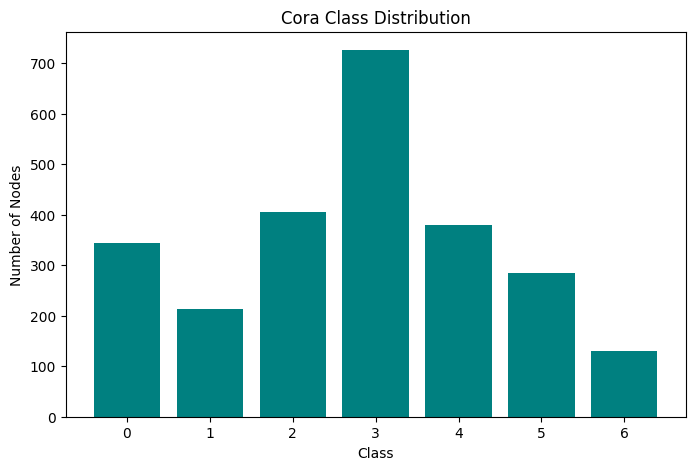

In [ ]:
plot_class_distribution(cora_data, "Cora")

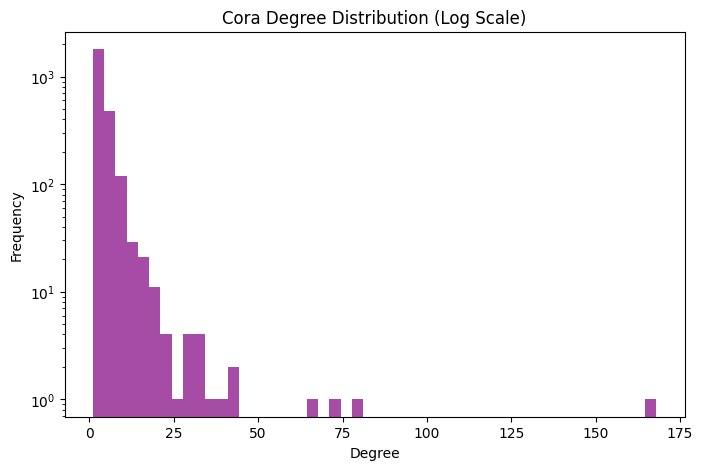

In [ ]:
plot_degree_distribution(cora_data, "Cora")

### **2. Citeseer Dataset**
#### **2.1 Graph Structure**
- Nodes ($|V|$): 2,120 academic publications.
- Edges ($|E|$): 3,679 undirected citation links.
- Classes ($|Y|$): 6 research categories (e.g., Artificial Intelligence, Databases).
- Average Degree: $\approx 3.5$.

#### **2.2 Node Features ($|X|$)**
- Feature Dimensionality: 3,703.
- Description: Bag-of-words vectors from paper abstracts, with broader vocabulary coverage than Cora.
- Sparsity: $\approx 0.08\%$ non-zero entries.

In [ ]:
citeseer_data = load_and_analyze_dataset("CiteSeer")

Processing...



CiteSeer Dataset Statistics:
Nodes (|V|): 2120
Edges (|E|): 3679
Features (|X|): 3703
Classes (|Y|): 6
Avg. Degree: 3.5
Feature Sparsity: 99.14%



Done!


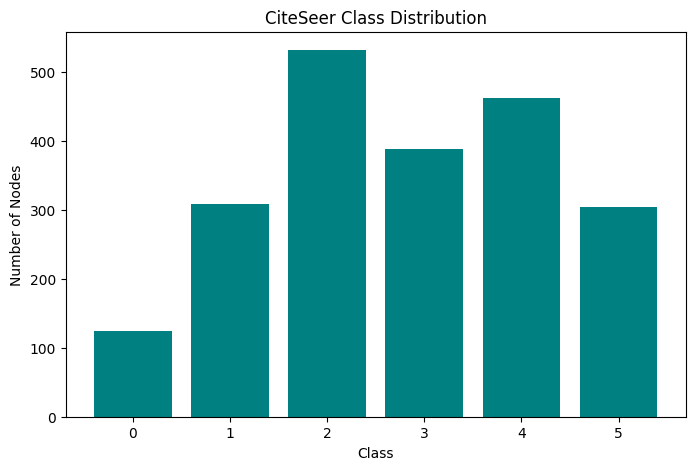

In [ ]:
plot_class_distribution(citeseer_data, "CiteSeer")

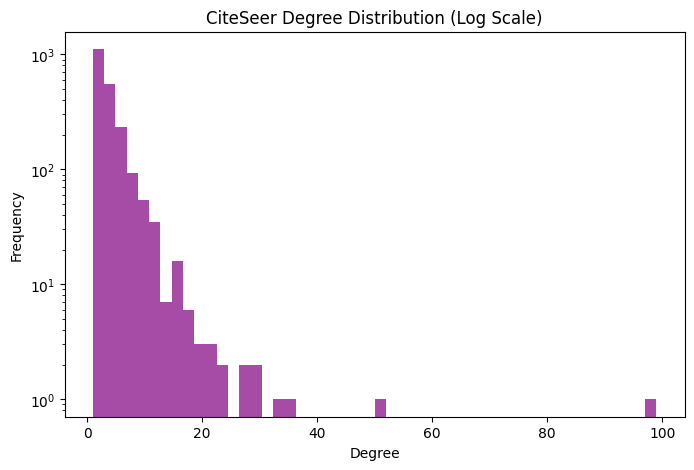

In [ ]:
plot_degree_distribution(citeseer_data, "CiteSeer")

### **3. Pubmed Dataset**
#### **3.1 Graph Structure**
- Nodes ($|V|$): 19,717 diabetes-related research papers.
- Edges ($|E|$): 44,325 undirected citations.
- Classes ($|Y|$): 3 subareas of diabetes research (e.g., Type 1 Diabetes, Immunology).
- Average Degree: $\approx 4.5$.

#### **3.2 Node Features ($|X|$)**
- Feature Dimensionality: 500.
- Description: TF-IDF weighted word vectors from paper abstracts, reduced to 500 dimensions by selecting the most frequent terms.
- Sparsity: $\approx 5\%$ non-zero entries.

In [ ]:
pubmed_data = load_and_analyze_dataset("PubMed")

Processing...



PubMed Dataset Statistics:
Nodes (|V|): 19717
Edges (|E|): 44324
Features (|X|): 500
Classes (|Y|): 3
Avg. Degree: 4.5
Feature Sparsity: 89.98%



Done!


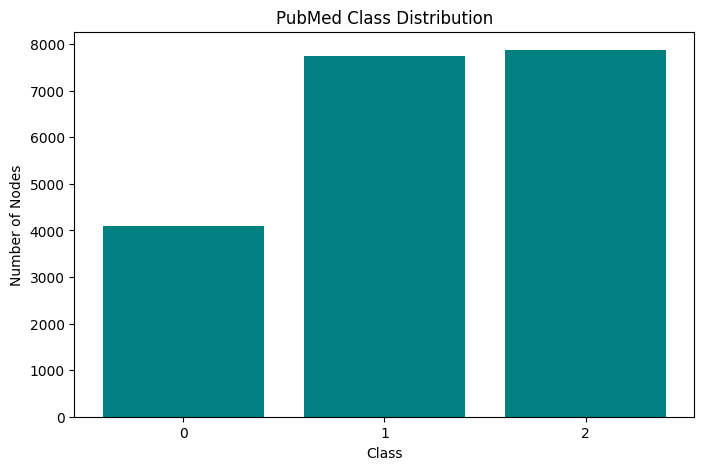

In [ ]:
plot_class_distribution(pubmed_data, "PubMed")

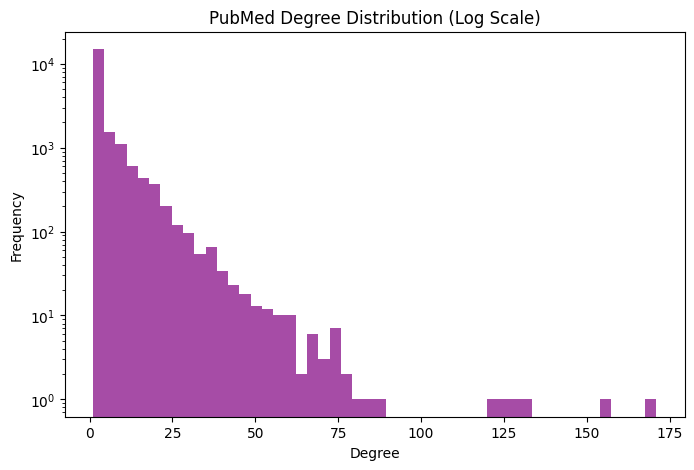

In [ ]:
plot_degree_distribution(pubmed_data, "PubMed")

### **4. Dataset Statistics**

| **Dataset**  | **Nodes (#V)** | **Edges (#E)** | **Features (#X)** | **Classes (#Y)** | **Avg. Degree** | **Feature Sparsity** |
|-------------|--------------|----------------|-------------|--------------|----------------|-------------|
| **Cora** | 2,485 | 5,069        | 1,433        | 7            | 4.1          | 98.72%         |
| **Citeseer** |  2,120  | 3,679 | 3,703        | 6            | 3.5          | 99.14% |
| **Pubmed** | 19,717  |  44,324  | 500  | 3            | 4.5          | 89.98%         |


## **Preprocessing: Normalization and Sparse Conversion**

The code below preprocesses graph data in two main steps:

- The first function converts the edge list into a sparse adjacency matrix, which reduces memory usage and speeds up computations by storing only the non-zero (existing edge) values. 
- The second function applies symmetric normalization using the formula $A_{\text{norm}} = D^{-1/2} A D^{-1/2}$, ensuring numerical stability, balanced influence among nodes, and efficient message passing by mitigating biases from high-degree nodes.

In [88]:
def edge_index_to_sparse_tensor(edge_index: torch.Tensor, num_nodes: int) -> torch.sparse.FloatTensor:
    """Converts an edge_index (2 x num_edges) to a torch.sparse.FloatTensor adjacency."""
    values = torch.ones(edge_index.size(1), dtype=torch.float32, device=edge_index.device)
    return torch.sparse.FloatTensor(edge_index, values, torch.Size([num_nodes, num_nodes]))

def normalize_sparse_tensor(adj: torch.sparse.FloatTensor) -> torch.sparse.FloatTensor:
    """
    Computes the symmetric normalization of a sparse adjacency matrix:
      A_norm = D^(-1/2) A D^(-1/2)
    """
    adj = adj.coalesce()  # Ensure the sparse tensor is coalesced.
    indices = adj.indices()
    values = adj.values()
    n = adj.size(0)
    deg = torch.zeros(n, device=values.device).scatter_add_(0, indices[0], values)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0.0
    new_values = deg_inv_sqrt[indices[0]] * values * deg_inv_sqrt[indices[1]]
    return torch.sparse.FloatTensor(indices, new_values, adj.size())

## **DMoN architecture**
### **1. GCN Layer**

In this implementation, we use a **Graph Convolutional Network (GCN)**, which follows the message-passing framework and computes node embeddings by iteratively aggregating information from neighbors.

Given a graph with **$N$ nodes**, let:
- **$X \in \mathbb{R}^{N \times d_{\text{in}}}$** be the **input feature matrix**, where each row represents the feature vector of a node.
- **$\tilde{A}$** be the **normalized adjacency matrix**, defined as:

  $$
  \tilde{A} = D^{-\frac{1}{2}} A D^{-\frac{1}{2}}
  $$

  where **$A \in \mathbb{R}^{N \times N}$** is the adjacency matrix and **$D$** is the diagonal degree matrix.

- **$W \in \mathbb{R}^{d_{\text{in}} \times d_{\text{out}}}$** is a trainable weight matrix that transforms node features.
- **$\sigma$** is the activation function, which in our case is **SELU** (Scaled Exponential Linear Unit).

The **GCN layer** computes the transformed node embeddings **$X^{(l+1)}$** in the following way:

$$
     X^{(l+1)} = \sigma \left( \tilde{A} X^{(l)} W + X^{(l)} W_{\text{skip}} \right)
$$
 where **$W_{\text{skip}}$** is a trainable diagonal weight matrix for the residual connection.

#### **Enhancements Over Standard GCN**
We introduce two key modifications to the standard GCN formulation:
1. **Skip Connection:**  
   - Instead of using a self-loop $\tilde{A} + I$, we introduce a **trainable skip connection** that allows direct propagation of the input feature matrix.

2. **SELU Activation:**  
   - Instead of **ReLU**, we use **SELU** (Scaled Exponential Linear Unit), which improves training stability and convergence.




In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class GCNLayer(nn.Module):
    """Implements GCN layer with additive skip connection and SELU activation."""
    def __init__(self, in_channels: int, out_channels: int, activation: str = 'selu', 
                 skip_connection: bool = True, no_features: bool = False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.skip_connection = skip_connection
        self.no_features = no_features

        # Activation function
        if activation is None:
            self.activation = lambda x: x
        elif activation.lower() == 'selu':
            self.activation = nn.SELU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        # Weight matrices
        effective_in_channels = in_channels if not no_features else 1
        self.weight = nn.Parameter(torch.empty(effective_in_channels, out_channels))
        if self.skip_connection:
            self.skip_weight = nn.Parameter(torch.empty(effective_in_channels, out_channels))
        self.bias = nn.Parameter(torch.empty(out_channels))

        # Initialization
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.skip_connection:
            nn.init.xavier_uniform_(self.skip_weight)
        nn.init.zeros_(self.bias)

    def forward(self, features: Tensor, graph: Tensor) -> Tensor:
        # Handle no-features mode (learnable node embeddings)
        if self.no_features:
            N = features.shape[0]
            weight = self.weight.expand(N, -1)  # [N, out_channels]
            output = torch.sparse.mm(graph, weight)
            if self.skip_connection:
                skip_weight = self.skip_weight.expand(N, -1)
                output = output + skip_weight
        else:
            # Standard GCN operation: ÃXW
            output = torch.sparse.mm(graph, features @ self.weight)
            # Add skip connection: XW_skip
            if self.skip_connection:
                output = output + (features @ self.skip_weight)
        
        # Add bias and apply activation
        output = output + self.bias
        return self.activation(output)

### **5.2 DMoN Network**

DMoN (Deep Modularity Networks) is an unsupervised clustering method for attributed graphs that leverages graph neural networks. It draws inspiration from the modularity quality function and its spectral optimization, resulting in a fully differentiable clustering objective. This objective optimizes soft cluster assignments while using a null model to account for inhomogeneities in the graph.

Let 
$$
C = \operatorname{softmax}(\text{GCN}(\tilde{A}, X))
$$ 
be the soft cluster assignment matrix, where:
- $\text{GCN}(\cdot)$ is a graph convolutional network defined above.

The DMoN loss function is defined as:
$$
L_{\text{DMoN}}(C; A) = -\frac{1}{2m} \operatorname{Tr}(C^\top B C) + \sqrt{\frac{k}{n}} \left\| C^\top \mathbf{1} \right\|_F^{-1},
$$
where:
- $m$ is the total number of edges,
- $B = A - \frac{dd^\top}{2m}$ is the modularity matrix (with $d$ being the degree vector),
- $\operatorname{Tr}(\cdot)$ is the trace operator, and
- $\|\cdot\|_F$ denotes the Frobenius norm.

The first term in the loss function maximizes the modularity by promoting dense intra-cluster connections relative to a null model, while the second term acts as collapse regularization. This regularizer prevents trivial solutions—such as assigning all nodes to a single cluster—by penalizing imbalanced cluster assignments.

In essence, DMoN combines ideas from spectral modularity maximization with a novel regularization approach. This balance allows for effective and efficient clustering on large-scale, sparse graphs.


In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

class DMoN(nn.Module):
    """PyTorch implementation of Deep Modularity Network (DMoN) layer."""
    def __init__(self, input_dim: int, n_clusters: int, collapse_regularization=0.1, 
                 dropout_rate=0, do_unpooling=False):
        super().__init__()
        self.n_clusters = n_clusters
        self.collapse_regularization = collapse_regularization
        self.dropout_rate = dropout_rate
        self.do_unpooling = do_unpooling
        self.gcn = GCNLayer(input_dim, n_clusters, activation=None)  # Output: [n_nodes, n_clusters]
        self.dropout = nn.Dropout(p=dropout_rate)
        
    def reset_parameters(self):
        self.gcn.reset_parameters()
        
    def forward(self, features: torch.Tensor, norm_adj: torch.sparse.FloatTensor, 
                raw_adj: torch.sparse.FloatTensor) -> tuple:
        # Generate assignments using GCN with normalized adjacency
        logits = self.gcn(features, norm_adj)  # GCN propagates features through norm_adj
        logits = self.dropout(logits)
        assignments = F.softmax(logits, dim=1)  # Softmax over clusters
        
        # Compute cluster sizes and assignments_pooling
        cluster_sizes = assignments.sum(dim=0)  # [n_clusters]
        assignments_pooling = assignments / (cluster_sizes.unsqueeze(0) + 1e-8)
        
        # Compute modularity loss using raw adjacency
        degrees = torch.sparse.sum(raw_adj, dim=1).to_dense().view(-1, 1)
        n_nodes = features.size(0)
        n_edges = degrees.sum()
        
        # C^T A C term (graph_pooled)
        pooled = torch.sparse.mm(raw_adj, assignments)
        graph_pooled = assignments.t() @ pooled
        
        # Null model term (normalizer)
        normalizer_left = assignments.t() @ degrees
        normalizer_right = degrees.t() @ assignments
        normalizer = (normalizer_left @ normalizer_right) / (2 * n_edges + 1e-8)
        
        # Spectral loss (modularity maximization)
        spectral_loss = -torch.trace(graph_pooled - normalizer) / (2 * n_edges + 1e-8)
        
        # Collapse regularization (matches math formula)
        collapse_loss = (torch.norm(cluster_sizes) / n_nodes * 
                         torch.sqrt(torch.tensor(self.n_clusters, dtype=degrees.dtype))) - 1
        total_loss = spectral_loss + self.collapse_regularization * collapse_loss
        
        # Pool features and apply SELU
        features_pooled = assignments_pooling.t() @ features
        features_pooled = F.selu(features_pooled)
        
        if self.do_unpooling:
            features_pooled = assignments_pooling @ features_pooled
        
        return features_pooled, assignments, total_loss


    def __repr__(self):
        return (f"DMoN(n_clusters={self.n_clusters}, "
                f"collapse_reg={self.collapse_regularization}, "
                f"dropout={self.dropout_rate}, "
                f"unpooling={self.do_unpooling})")

### **5.4 Evaluation Metrics**

Below are the evaluation metrics used to assess clustering performance, along with their aims and mathematical formulations.

#### **5.4.1. Pairwise Precision**
**Aim**: Measures the proportion of correctly predicted same-cluster pairs among all predicted same-cluster pairs.  
**Formula**:  
$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$  
**Explanation**:  
- **True Positives (TP)**: Pairs of nodes that are in the same cluster in both ground truth and predictions.  
- **False Positives (FP)**: Pairs of nodes predicted to be in the same cluster but belong to different ground-truth clusters.

In [91]:
"""Clustering metric implementation (pairwise and graph-based)."""
from typing import Tuple
import numpy as np
from scipy.sparse import base
from sklearn.metrics import cluster
from scipy.optimize import linear_sum_assignment

def _pairwise_confusion(y_true,y_pred):

  contingency = cluster.contingency_matrix(y_true, y_pred)
  same_class_true = np.max(contingency, 1)
  same_class_pred = np.max(contingency, 0)
  diff_class_true = contingency.sum(axis=1) - same_class_true
  diff_class_pred = contingency.sum(axis=0) - same_class_pred
  total = contingency.sum()

  true_positives = (same_class_true * (same_class_true - 1)).sum()
  false_positives = (diff_class_true * same_class_true * 2).sum()
  false_negatives = (diff_class_pred * same_class_pred * 2).sum()
  true_negatives = total * (
      total - 1) - true_positives - false_positives - false_negatives

  return true_positives, false_positives, false_negatives, true_negatives

def pairwise_precision(y_true, y_pred):
  true_positives, false_positives, _, _ = _pairwise_confusion(y_true, y_pred)
  return true_positives / (true_positives + false_positives)

#### **5.4.2. Pairwise Recall**
**Aim**: Measures the proportion of correctly predicted same-cluster pairs among all true same-cluster pairs.  
**Formula**:  
$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$  

In [92]:

def pairwise_recall(y_true, y_pred):
  true_positives, _, false_negatives, _ = _pairwise_confusion(y_true, y_pred)
  return true_positives / (true_positives + false_negatives)

#### **5.4.3. Pairwise Accuracy**
**Aim**: Measures the overall correctness of pairwise cluster assignments.  
**Formula**:  
$$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{FN} + \text{TN}}
$$ 

In [93]:
def pairwise_accuracy(y_true, y_pred):
  true_pos, false_pos, false_neg, true_neg = _pairwise_confusion(y_true, y_pred)
  return (true_pos + false_pos) / (true_pos + false_pos + false_neg + true_neg)

#### **5.4.4. Clustering Accuracy (Hungarian Algorithm)**
**Aim**: Matches predicted clusters to ground-truth labels optimally and computes accuracy.  
**Formula**:  
$$
\text{Accuracy} = \frac{\sum \text{Correct Matches via Hungarian Assignment}}{N}
$$  
**Explanation**:  
- Uses the Hungarian algorithm to align predicted clusters with ground-truth labels.  
- Computes the fraction of nodes assigned to the correct cluster after optimal alignment.

In [94]:
def clustering_accuracy(y_true, y_pred):
    """
    Computes clustering accuracy using the Hungarian algorithm.
    Both y_true and y_pred should be 1D arrays of labels.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_true.size):
        w[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return sum(w[row_ind, col_ind]) / y_true.size


### **5.4.5 F1 Score**
**Aim:** Quantify the balance between precision and recall.

**Formula:** 
 $$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [95]:
def pairwise_f1(y_true, y_pred):
    precision = pairwise_precision(y_true, y_pred)
    recall = pairwise_recall(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall)

#### **5.4.5. Modularity**
**Aim**: Quantifies the quality of graph clustering by comparing intra-cluster edges to a random null model.  
**Formula**:  
$$
Q = \frac{1}{2m} \sum_{i,j} \left[ A_{ij} - \frac{d_i d_j}{2m} \right] \delta(c_i, c_j)
$$  
**Where**:  
- $ A_{ij} $: Adjacency matrix entry (1 if edge exists between $i$ and $j$, 0 otherwise).  
- $ d_i $: Degree of node $i$.  
- $ m $: Total number of edges.  
- $ \delta(c_i, c_j) $: 1 if $i$ and $j$ are in the same cluster, 0 otherwise.  

**Explanation**:  
- Higher modularity ($\uparrow Q$) indicates better clustering.  
- Penalizes trivial solutions (e.g., all nodes in one cluster).

In [96]:
def modularity(adjacency, clusters):
    """Computes graph modularity.

    Args:
      adjacency: Input graph in terms of its sparse adjacency matrix.
      clusters: An (n,) int cluster vector.

    Returns:
      The value of graph modularity.
      https://en.wikipedia.org/wiki/Modularity_(networks)
    """
    import scipy.sparse
    # Ensure the matrix is in CSR format for subscriptability.
    if not isinstance(adjacency, scipy.sparse.csr_matrix):
        adjacency = adjacency.tocsr()
    degrees = adjacency.sum(axis=0).A1
    n_edges = degrees.sum()  # Note: this is 2*m for undirected graphs.
    result = 0
    for cluster_id in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster_id)[0]
        # Now adjacency is CSR so we can use slicing.
        adj_submatrix = adjacency[cluster_indices, :][:, cluster_indices]
        degrees_submatrix = degrees[cluster_indices]
        result += np.sum(adj_submatrix) - (np.sum(degrees_submatrix)**2) / (n_edges + 1e-8)
    return result / (n_edges + 1e-8)

#### **5.4.6. Normalized Mutual Information (NMI)**

**Aim**: Quantifies the agreement between predicted clusters and ground-truth labels, adjusted for chance.

**Formula**:  
$$
\text{NMI}(Y, C) = \frac{2 \cdot I(Y; C)}{H(Y) + H(C)}
$$

where:  
- $I(Y; C)$: Mutual Information between true labels $Y$ and predicted clusters $C$.  
- $H(Y)$, $H(C)$: Entropies of $Y$ and $C$.

**Formulations**:

- **Mutual Information**:  
  $$ 
  I(Y; C) = \sum_{y \in Y} \sum_{c \in C} p(y, c) \log \frac{p(y, c)}{p(y) p(c)}
  $$  
  where $p(y, c)$ is the joint probability of $y$ and $c$, and $p(y)$, $p(c)$ are the marginal probabilities.

- **Entropy**:  
  $$ 
  H(Y) = - \sum_{y \in Y} p(y) \log p(y)
  $$  
  $$ 
  H(C) = - \sum_{c \in C} p(c) \log p(c)
  $$

**Explanation**:  
- **Mutual Information** measures how much knowing $C$ reduces uncertainty about $Y$ (and vice versa).  
- **Entropy** quantifies the uncertainty or randomness in $Y$ or $C$.  
- **Normalization** scales NMI to the range $[0, 1]$, where $1$ represents perfect alignment with the ground truth and $0$ indicates no statistical dependency (i.e., random clustering).

**Implications**:  
- Higher NMI ($\uparrow$) indicates better clustering quality.  
- Robust to imbalanced class sizes (unlike accuracy).  
- Requires labeled data (supervised evaluation).

**Note**: The implementation will utilize the `sklearn.metrics.normalized_mutual_info_score` module to compute this metric.


### **5.5 Training the DMoN Model**

In [98]:
import torch
import torch.optim as optim
from torch_geometric.utils import to_scipy_sparse_matrix


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_DMoNNet(data, collapse_reg=0.1, dropout_rate=0.5, 
                  n_clusters=16, n_epochs=200, learning_rate=0.001, logging=False):
    n_nodes = data.num_nodes

    # Build raw adjacency from edge_index and compute normalized adjacency.
    raw_adj = edge_index_to_sparse_tensor(data.edge_index, n_nodes).to(device)
    norm_adj = normalize_sparse_tensor(raw_adj).to(device)

    # Use node features from the data and move to device.
    features = data.x.float().to(device)
    
    # Build model and move it to device.
    model = DMoN(input_dim=data.num_features, n_clusters=n_clusters,
                 collapse_regularization=collapse_reg, dropout_rate=dropout_rate,
                 do_unpooling=False).to(device)
    
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop.
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        pool, assignments, loss = model(features, norm_adj, raw_adj)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        if logging and epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

    # After training, obtain cluster assignments.
    model.eval()
    with torch.no_grad():
        _, assignments, _ = model(features, norm_adj, raw_adj)
    assignments_np = assignments.cpu().numpy()
    clusters = assignments_np.argmax(axis=1)  # Convert soft assignments to hard clusters.
    
    return clusters

## **Additional baseline models**

# **DiffPool — Mathematical Description**

**Reference**  
Ying, R., You, J., Morris, C., Ren, X., Hamilton, W., & Leskovec, J. (2018).  
[*Hierarchical Graph Representation Learning with Differentiable Pooling*](https://proceedings.neurips.cc/paper/2018/hash/772c7312ed0b3e39e67da742da353121-Abstract.html).  
In *Advances in Neural Information Processing Systems (NeurIPS 2018)*.

**DiffPool** is an early **differentiable graph pooling** method that learns hierarchical cluster assignments of the nodes, allowing end-to-end graph representation learning.

---

## 1. Setup

We have a graph $G = (V, E)$ with:
- $n = |V|$ nodes,
- adjacency matrix $\mathbf{A} \in \mathbb{R}^{n \times n}$,
- feature matrix $\mathbf{X} \in \mathbb{R}^{n \times d_x}$.

The goal is to learn **coarser** graph representations by grouping nodes into clusters in a **differentiable** manner, enabling end-to-end training with downstream tasks (e.g., graph classification).


## 2. Single-Layer DiffPool Implementation

This section reflects the **PyTorch implementation** provided, which uses a **single-layer GCN** for simplicity.

### 2.1 Node Embeddings
1. **Single GCN Layer** computes node embeddings:
   $$
   \mathbf{H} = \text{ReLU}\bigl(\text{GCNConv}(\mathbf{X}, \mathbf{A})\bigr)
   $$
   where $\mathbf{H} \in \mathbb{R}^{n \times h}$ is the hidden embedding matrix.

### 2.2 Assignment Matrix
1. **MLP Projection** maps embeddings to cluster assignments:
   $$
   \mathbf{S} = \text{softmax}\bigl(\text{MLP}(\mathbf{H})\bigr) \quad \text{where} \quad \mathbf{S} \in \mathbb{R}^{n \times k}
   $$
   - Each row $\mathbf{S}_i \in \mathbb{R}^k$ is a soft cluster assignment vector for node $i$.

2. **Column Normalization** for pooling stability:
   $$
   \mathbf{S}_{\text{pool}} = \mathbf{S} \oslash \left(\mathbf{1}_n^T \mathbf{S} + \epsilon \right)
   $$
   where $\oslash$ denotes element-wise division, ensuring columns of $\mathbf{S}_{\text{pool}}$ sum to 1.

### 2.3 Feature Pooling
1. **Pooled Features** with SELU activation:
   $$
   \mathbf{H}_{\text{pool}} = \text{SELU}\left(\mathbf{S}_{\text{pool}}^\top \mathbf{H}\right)
   $$
   - $\mathbf{H}_{\text{pool}} \in \mathbb{R}^{k \times h}$ represents cluster embeddings.

2. **Optional Unpooling** (if `do_unpool=True`):
   $$
   \mathbf{H}_{\text{unpool}} = \mathbf{S}_{\text{pool}} \mathbf{H}_{\text{pool}}
   $$
   Maps pooled features back to node space for hierarchical processing.


## 3. Objective

### 3.1 Loss Functions
1. **Link Reconstruction Loss** (MSE between $\mathbf{A}$ and $\mathbf{S}\mathbf{S}^\top$):
   $$
   \mathcal{L}_{\text{link}} = \left\| \mathbf{A} - \mathbf{S}\mathbf{S}^\top \right\|_F^2
   $$

2. **Entropy Regularization** (penalizes uncertain assignments):
   $$
   \mathcal{L}_{\text{ent}} = -\frac{1}{n} \sum_{i=1}^n \sum_{j=1}^k \mathbf{S}_{ij} \log(\mathbf{S}_{ij} + \epsilon)
   $$

3. **Total Loss** (weighted sum):
   $$
   \mathcal{L}_{\text{total}} = \alpha \mathcal{L}_{\text{link}} + \beta \mathcal{L}_{\text{ent}}
   $$
   where $\alpha, \beta$ balance the loss terms.


## 4. Cluster Assignments

Final clusters are derived via **row-wise argmax** on $\mathbf{S}$:
$$
\text{clusters}_i = \arg\max_j \mathbf{S}_{ij} \quad \forall i \in \{1, \dots, n\}
$$


## 5. Implementation Notes

1. **Single-Layer Focus**: Unlike the original DiffPool (hierarchical), this implementation uses **one GCN layer** to align with GNN-based baselines.
2. **Column Normalization**: Added to stabilize pooling (absent in the original paper).
3. **SELU Activation**: Used post-pooling for improved feature scaling.


## 6. Summary

This implementation adapts DiffPool for **single-layer GCNs** while preserving core ideas:
- Soft cluster assignments via $\mathbf{S}$,
- Link reconstruction and entropy regularization,
- Column-normalized pooling for stability.

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import GCNConv

def train_diffpool(data, n_clusters, hidden_channels=64, epochs=200, alpha=1.0, beta=1.0, do_unpool=False):
    class DiffPoolNet(nn.Module):
        def __init__(self, in_channels, hidden_channels, num_clusters, do_unpool=False):
            super().__init__()
            # Single GCN layer (as per user's request for single-layer)
            self.gcn = GCNConv(in_channels, hidden_channels)
            # Assignment network
            self.assign_net = nn.Sequential(
                nn.Linear(hidden_channels, 256),
                nn.ReLU(),
                nn.Linear(256, num_clusters)
            )
            self.do_unpool = do_unpool

        def forward(self, x, edge_index, batch):
            # GCN to get node embeddings
            h = F.relu(self.gcn(x, edge_index))
            
            # Compute assignments (row-wise softmax)
            s = self.assign_net(h)
            s = F.softmax(s, dim=-1)
            
            # Column-normalize assignments for pooling (TensorFlow logic)
            s_pool = s / (s.sum(dim=0, keepdim=True) + 1e-10)  # Avoid division by zero
            
            # Pool features: S_pool^T @ H
            pooled = torch.mm(s_pool.t(), h)
            pooled = F.selu(pooled)  # SELU activation as in TensorFlow
            
            # Optional unpooling (if needed)
            if self.do_unpool:
                pooled = torch.mm(s_pool, pooled)
            
            return pooled, s  # Return pooled features and assignments

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
    model = DiffPoolNet(data.num_features, hidden_channels, n_clusters, do_unpool).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    data = data.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass (we ignore pooled features since loss depends on assignments)
        _, s = model(data.x, data.edge_index, batch)
        
        # Convert edge_index to dense adjacency matrix
        A_dense = to_dense_adj(data.edge_index, batch=batch)[0]
        
        # Link reconstruction loss (uses original assignments)
        A_recon = torch.matmul(s, s.t())
        loss_link = F.mse_loss(A_recon, A_dense)
        
        # Entropy regularization (on original assignments)
        entropy = -s * torch.log(s + 1e-10)
        loss_ent = torch.mean(torch.sum(entropy, dim=-1))
        
        # Weighted total loss
        loss = alpha * loss_link + beta * loss_ent
        loss.backward()
        optimizer.step()

    # Get final cluster assignments
    model.eval()
    with torch.no_grad():
        _, s = model(data.x, data.edge_index, batch)
    clusters = s.argmax(dim=1).cpu().numpy()
    return clusters

# **MinCutPool — Mathematical Description**

**Reference**  
Bianchi, F., Grattarola, D., & Alippi, C. (2020).  
[*Spectral Clustering with Graph Neural Networks for Graph Pooling (MinCutPool)*](https://arxiv.org/abs/2002.11097).  
Presented at *International Conference on Machine Learning (ICML 2020)* Workshops.

**MinCutPool** learns **soft cluster assignments** by optimizing a relaxed mincut objective with **orthogonality** and **cluster balance** constraints. The provided TensorFlow code integrates this with a GCN backbone.

---

## 1. Setup

Given a graph $G = (V, E)$ with:
- $n = |V|$ nodes,
- adjacency matrix $\mathbf{A} \in \mathbb{R}^{n \times n}$ (sparse),
- feature matrix $\mathbf{X} \in \mathbb{R}^{n \times d_x}$,
- GCN-processed features $\mathbf{H} \in \mathbb{R}^{n \times h}$ (output of previous layers).

The goal is to compute:
1. **Assignment matrix** $\mathbf{S} \in \mathbb{R}^{n \times k}$ (soft clusters),
2. **Pooled features** $\mathbf{Z} \in \mathbb{R}^{k \times h}$.

## 2. Assignment Matrix

### 2.1 MLP Projection
1. **MLP Architecture** (from code):
   - Layers: `mlp_sizes` with SELU activations and dropout (`dropout_rate`).
   - Final layer: Linear projection to $k$ units with **orthogonal initialization**.
   $$
   \mathbf{S}_{\text{raw}} = \text{MLP}(\mathbf{H})
   $$
2. **Softmax Normalization**:
   $$
   \mathbf{S} = \text{softmax}(\mathbf{S}_{\text{raw}}, \text{axis}=1)
   $$
   Each row $\mathbf{S}_i$ is a soft cluster assignment for node $i$.

### 2.2 Column-Normalized Pooling
For stable feature pooling:
$$
\mathbf{S}_{\text{pool}} = \mathbf{S} \oslash \left(\mathbf{1}_n^T \mathbf{S} + \epsilon \right)
$$
where $\oslash$ is element-wise division (columns sum to 1).


## 3. Pooled Features & Graph

1. **Feature Pooling** (with SELU activation):
   $$
   \mathbf{Z} = \text{SELU}\left(\mathbf{S}_{\text{pool}}^\top \mathbf{H}\right)
   $$
2. **Optional Unpooling** (if `do_unpool=True`):
   $$
   \mathbf{Z}_{\text{unpool}} = \mathbf{S}_{\text{pool}} \mathbf{Z}
   $$


## 4. Loss Functions

### 4.1 Spectral Loss (Mincut Objective)
Maximizes intra-cluster edges relative to cluster volume:
$$
\mathcal{L}_{\text{spectral}} = -\frac{\text{Tr}(\mathbf{S}^\top \mathbf{A} \mathbf{S})}{\text{Tr}(\mathbf{S}^\top \mathbf{D} \mathbf{S})}
$$
where $\mathbf{D}$ is the degree matrix ($\mathbf{D}_{ii} = \sum_j \mathbf{A}_{ij}$).

### 4.2 Orthogonality Loss
Penalizes non-orthogonal clusters:
$$
\mathcal{L}_{\text{ortho}} = \lambda_{\text{ortho}} \left\| \frac{\mathbf{S}^\top \mathbf{S}}{\|\mathbf{S}^\top \mathbf{S}\|_F} - \frac{\mathbf{I}_k}{\sqrt{k}} \right\|_F
$$
- $\lambda_{\text{ortho}}$ = `orthogonality_regularization`.

### 4.3 Cluster Size Loss
Encourages balanced clusters:
$$
\mathcal{L}_{\text{size}} = \lambda_{\text{size}} \left( \frac{\|\mathbf{1}_n^\top \mathbf{S}\|_2}{n \sqrt{k}} - 1 \right)
$$
- $\lambda_{\text{size}}$ = `cluster_size_regularization`.

### 4.4 Total Loss
$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{spectral}} + \mathcal{L}_{\text{ortho}} + \mathcal{L}_{\text{size}}
$$

## 5. Summary

The code implements **MinCutPool** as:
1. A **GCN backbone** for node embeddings.
2. An **MLP** with SELU/dropout to compute cluster assignments.
3. **Three losses**: spectral (mincut), orthogonality, and cluster balance.
4. **Column-normalized pooling** for stable feature aggregation.

This aligns with the paper’s theory but adds practical enhancements (normalization, dropout, sparse math) for stability and performance.

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import GCNConv

def train_mincut_pool(data, n_clusters, hidden_channels=64, epochs=200,
                ortho_reg=1.0, cluster_reg=0.0, dropout_rate=0.0, 
                mlp_sizes=[256], do_unpool=False):
    class MincutPoolNet(nn.Module):
        def __init__(self, in_channels, hidden_channels, n_clusters, 
                     mlp_sizes, dropout_rate, do_unpool):
            super().__init__()
            # Single-layer GCN
            self.gcn = GCNConv(in_channels, hidden_channels)
            # MLP for assignments
            mlp_layers = []
            for size in mlp_sizes:
                mlp_layers.append(nn.Linear(hidden_channels, size))
                mlp_layers.append(nn.SELU())
                mlp_layers.append(nn.Dropout(dropout_rate))
            mlp_layers.append(nn.Linear(mlp_sizes[-1], n_clusters))
            # Orthogonal initialization for last layer
            nn.init.orthogonal_(mlp_layers[-1].weight)
            nn.init.zeros_(mlp_layers[-1].bias)
            self.mlp = nn.Sequential(*mlp_layers)
            self.do_unpool = do_unpool

        def forward(self, x, edge_index, batch):
            # GCN to get node embeddings
            h = F.relu(self.gcn(x, edge_index))
            # Compute assignments
            s_raw = self.mlp(h)
            s = F.softmax(s_raw, dim=-1)
            # Column-normalize assignments
            s_pool = s / (s.sum(dim=0, keepdim=True) + 1e-10)
            return h, s, s_pool

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MincutPoolNet(data.num_features, hidden_channels, n_clusters,
                          mlp_sizes, dropout_rate, do_unpool).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    data = data.to(device)
    batch = torch.zeros(data.num_nodes, dtype=torch.long, device=device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        h, s, s_pool = model(data.x, data.edge_index, batch)
        A_dense = to_dense_adj(data.edge_index, batch=batch)[0]

        # Spectral Loss (Mincut)
        s_t = s.t()
        numerator = torch.trace(torch.mm(torch.mm(s_t, A_dense), s))
        D = torch.diag(A_dense.sum(dim=1))
        denominator = torch.trace(torch.mm(torch.mm(s_t, D), s))
        spectral_loss = - (numerator / denominator)

        # Orthogonality Loss
        pairwise = torch.mm(s_t, s)
        pairwise_norm = pairwise / torch.norm(pairwise, p='fro')
        identity = torch.eye(n_clusters, device=device) / np.sqrt(n_clusters)
        ortho_loss = torch.norm(pairwise_norm - identity)

        # Cluster Size Loss
        cluster_sum = torch.sum(pairwise, dim=1)
        cluster_loss = (torch.norm(cluster_sum) / 
                        (data.num_nodes * np.sqrt(n_clusters))) - 1

        # Total Loss
        total_loss = (spectral_loss + 
                      ortho_reg * ortho_loss + 
                      cluster_reg * cluster_loss)
        
        total_loss.backward()
        optimizer.step()

    # Get final cluster assignments
    model.eval()
    with torch.no_grad():
        _, s, _ = model(data.x, data.edge_index, batch)
    clusters = s.argmax(dim=1).cpu().numpy()
    return clusters

## **Experiments**

In [ ]:
import numpy as np
import torch
from torch_geometric.data import Data
from pathlib import Path
from sklearn.metrics import normalized_mutual_info_score
import torch
import torch.optim as optim
from torch_geometric.utils import to_scipy_sparse_matrix
import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
import torch
from torch_geometric.utils import to_scipy_sparse_matrix


path = Path(r"C:\Users\Aymane\Desktop\adc_sbm_datasets")

# ------------------------------------------------------------------------------
# Helper function to convert synthetic data into a PyG Data object.
def convert_synthetic_to_pyg(edge_list, n_nodes, features, labels=None):
    """
    Convert synthetic dataset to a PyG Data object.
    """
    edge_index = torch.tensor(edge_list.T, dtype=torch.long)
    x = torch.tensor(features, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, num_nodes=n_nodes)
    if labels is not None:
        data.y = torch.tensor(labels, dtype=torch.long)
    return data


def evaluate_baselines_for_datasets_with_repeats(dataset_names=["PubMed", "Cora", "Citeseer"], num_runs: int = 5):
    rows = []
    for ds in dataset_names:
        print(f"\nEvaluating dataset: {ds}")
        # Load dataset (this function should return a PyG Data object with attributes x, edge_index, y, and num_nodes)
        data = load_and_analyze_dataset(ds)
        data = data.to(device)
        labels = data.y.cpu().numpy()
        n_clusters = len(np.unique(labels))
        print(f"Detected n_clusters = {n_clusters}")
        
        # Create the adjacency matrix (SciPy sparse) from edge_index.
        adj_matrix = to_scipy_sparse_matrix(data.edge_index, num_nodes=data.num_nodes)
        
        # Define baseline methods (they are assumed to take data and n_clusters and return cluster assignments).
        baselines = {
            'DiffPool': lambda: train_diffpool(data, n_clusters),
            'MinCutPool': lambda: train_mincut_pool(data, n_clusters),
            'DMon': lambda: train_DMoNNet(data, n_clusters=n_clusters),
        }
        
        for baseline_name, method in baselines.items():
            nmi_list, cond_list, mod_list, f1_list, acc_list = [], [], [], [], []
            for run in range(num_runs):
                try:
                    clusters = method()
                    nmi = normalized_mutual_info_score(labels, clusters)
                    acc = clustering_accuracy(labels, clusters)
                    cond = conductance(adj_matrix, clusters)
                    mod = modularity(adj_matrix, clusters)
                    precision = pairwise_precision(labels, clusters)
                    recall = pairwise_recall(labels, clusters)
                    f1 = 2 * precision * recall / (precision + recall + 1e-8)
                    
                    nmi_list.append(nmi)
                    cond_list.append(cond)
                    mod_list.append(mod)
                    f1_list.append(f1)
                    acc_list.append(acc)
                except Exception as e:
                    print(f"{baseline_name} run {run} failed: {e}")
            if len(nmi_list) > 0:
                row = {
                    "Dataset": ds,
                    "Baseline": baseline_name,
                    "n_clusters": n_clusters,
                    "NMI": f"{np.mean(nmi_list):.4f} ± {np.std(nmi_list):.4f}",
                    "Conductance": f"{np.mean(cond_list):.4f} ± {np.std(cond_list):.4f}",
                    "Modularity": f"{np.mean(mod_list):.4f} ± {np.std(mod_list):.4f}",
                    "F1": f"{np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}",
                    "Accuracy": f"{np.mean(acc_list):.4f} ± {np.std(acc_list):.4f}",
                }
                rows.append(row)
        print("-" * 40)
    df = pd.DataFrame(rows)
    print("\nResults:")
    print(df)
    return df

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import normalized_mutual_info_score

def evaluate_synthetic_nmi_across_scenarios_with_repeats(base_dir: Path = None, num_runs: int = 5):
    
    # Define your baseline methods here.
    baselines = {
        'DiffPool': lambda data, n_clusters: train_diffpool(data, n_clusters),
        'MinCutPool': lambda data, n_clusters: train_mincut_pool(data, n_clusters),
        'DMon': lambda data, n_clusters: train_DMoNNet(data, n_clusters=n_clusters)
    }
    
    rows = []
    # Iterate over each scenario subdirectory.
    for scenario_dir in base_dir.iterdir():
        if scenario_dir.is_dir():
            scenario_name = scenario_dir.name
            print(f"Scenario: {scenario_name}")
            # Look for graph files ending with '_graph.npz'
            for graph_file in scenario_dir.glob("*_graph.npz"):
                # Derive the dataset name from the file name.
                dataset_name = graph_file.stem.replace("_graph", "")
                try:
                    # Load dataset (assumes load_dataset returns: edge_list, n_nodes, block_membership, feature_blocks, features)
                    edge_list, n_nodes, block_membership, feature_blocks, features = load_dataset(scenario_dir, dataset_name)
                    true_labels = block_membership  # Ground-truth clustering labels.
                    # Convert to a PyG Data object, attaching the labels.
                    data = convert_synthetic_to_pyg(edge_list, n_nodes, features, labels=true_labels)
                    # Determine the number of clusters from ground-truth.
                    n_clusters = len(np.unique(true_labels))
                    
                    for baseline_name, method in baselines.items():
                        nmies = []
                        for run in range(num_runs):
                            clusters = method(data, n_clusters)
                            nmi = normalized_mutual_info_score(true_labels, clusters)
                            nmies.append(nmi)
                        nmies = np.array(nmies)
                        mean_nmi = nmies.mean()
                        std_nmi = nmies.std()
                        # Append results to our rows.
                        rows.append({
                            "Scenario": scenario_name,
                            "Dataset": dataset_name,
                            "Baseline": baseline_name,
                            "n_clusters": n_clusters,
                            "NMI": f"{mean_nmi:.4f} ± {std_nmi:.4f}"
                        })
                except Exception as e:
                    print(f"Failed to evaluate dataset {dataset_name}: {e}")
    # Create a DataFrame from the results.
    df = pd.DataFrame(rows)
    print("\nResults:")
    print(df)
    return df

if __name__ == "__main__":
    # Adjust base_dir if necessary.
    df_results_synthetic_data = evaluate_synthetic_nmi_across_scenarios_with_repeats(path, num_runs=5)
    df_results_synthetic_data.to_csv("results_synthetic_data.csv", index=False)
    
    df_results_real_data = evaluate_baselines_for_datasets_with_repeats(["Cora", "Citeseer", "PubMed"], num_runs=5)
    df_results_real_data.to_csv("results_real_data.csv", index=False)

    print("Evaluation completed. Results saved to CSV files.")

Evaluation completed. Results saved to CSV files.


## **Results**

### **Results for synthetic data**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # Ensure pandas is imported since it's used in the code

def plot_synthetic_results_with_std(df):
    
    # Map each scenario name to its parameter name and preferred x-scale ("linear" or "log").
    scenario_params = {
        "scenario_1_dout": ("d_out", "linear"),
        "scenario_2_sigmac_independent": ("sigma_c", "log"),
        "scenario_3_sigmac_nested": ("sigma_c", "log"),
        "scenario_4_sigmac_grouped": ("sigma_c", "log"),
        "scenario_5_degree": ("d", "log"),
        "scenario_6_dmax": ("d_max", "log"),
    }
    
    # Sort scenarios by name (so they appear in numerical order).
    unique_scenarios = sorted(df["Scenario"].unique())
    
    # Create subplots. Adjust rows/cols as needed; here we assume 2x3 for 6 scenarios.
    fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
    axes = axes.flatten()  # Flatten to easily iterate.
    

    def parse_dataset_value(dataset_name, param):
        prefix = param + "_"
        val_str = dataset_name.replace(prefix, "")
        val_str = val_str.replace("_", ".")
        try:
            return float(val_str)
        except ValueError:
            return np.nan
    
    def parse_mean_std_nmi(nmi_str):
        parts = nmi_str.split("±")
        mean_val = float(parts[0].strip())
        std_val = 0.0
        if len(parts) > 1:
            std_val = float(parts[1].strip())
        return mean_val, std_val
    
    for i, scenario_name in enumerate(unique_scenarios):
        ax = axes[i]
        
        # Determine the parameter name and scale (log or linear).
        param_name, xscale = scenario_params.get(scenario_name, ("param", "linear"))
        
        # Filter the DataFrame for this scenario.
        scenario_df = df[df["Scenario"] == scenario_name].copy()
        
        # Parse numeric param value from the "Dataset" column.
        scenario_df["param_value"] = scenario_df["Dataset"].apply(
            lambda ds: parse_dataset_value(ds, param_name)
        )
        
        # Parse mean NMI and std from the "NMI" column.
        scenario_df[["mean_nmi", "std_nmi"]] = scenario_df["NMI"].apply(
            lambda nmi_str: pd.Series(parse_mean_std_nmi(nmi_str))
        )
        
        # Plot each baseline as a separate line with fill.
        for baseline in scenario_df["Baseline"].unique():
            bdf = scenario_df[scenario_df["Baseline"] == baseline].copy()
            bdf = bdf.sort_values("param_value")
            
            x = bdf["param_value"].values
            y_mean = bdf["mean_nmi"].values * 100  # Convert to percentage
            y_std = bdf["std_nmi"].values * 100
            
            ax.plot(x, y_mean, label=baseline, marker="o")
            ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2)
        
        ax.set_xscale(xscale)
        ax.set_xlabel(param_name)
        ax.set_ylabel("NMI × 100" if i % 3 == 0 else "")  # Label y-axis for leftmost subplots
        ax.set_title(scenario_name)
    
    # Create a single legend below the plots with larger font size.
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=len(labels), bbox_to_anchor=(0.5, -0.02), fontsize=14)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend.
    
    # Save the figure as a PNG file.
    plt.savefig(r"C:\Users\Aymane\Desktop\synthetic_results.png", dpi=300)
    plt.show()


In [ ]:
df_results_synthetic_data = pd.read_csv("results_synthetic_datav.csv")

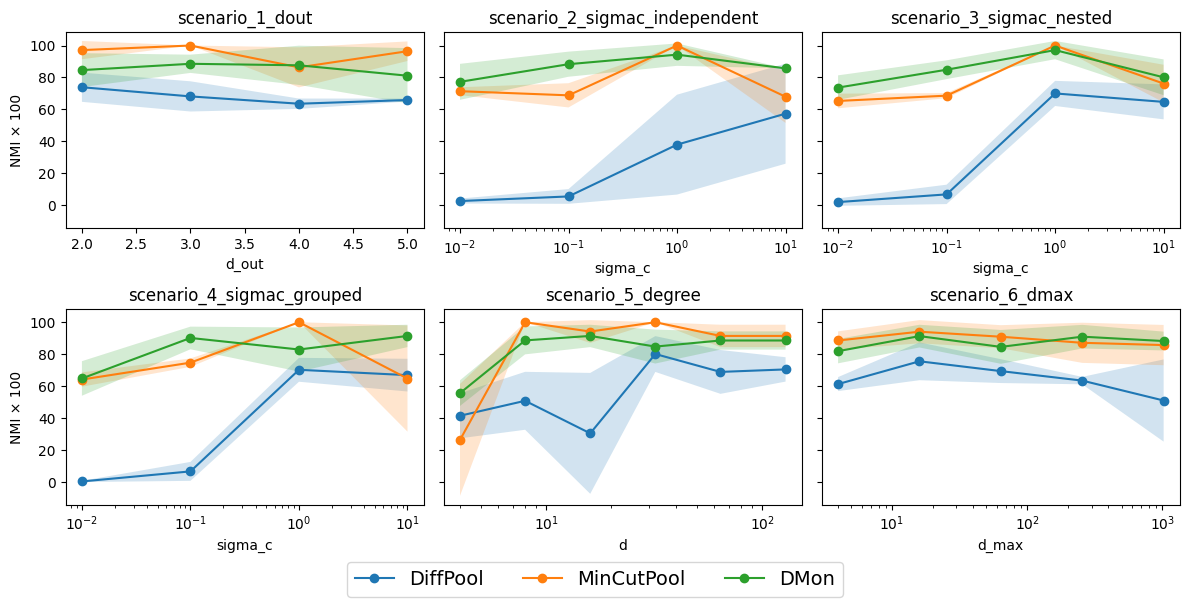

In [73]:
plot_synthetic_results_with_std(df_results_synthetic_data)

### **Results for real data**

In [82]:
df_results_real_data = pd.read_csv("results_real_data.csv")
df_results_real_data.pivot(index=["Baseline"], columns="Dataset", values = "NMI")

Dataset,Citeseer,Cora,PubMed
Baseline,,,
DMon,0.2827 ± 0.0384,0.4668 ± 0.0231,0.0841 ± 0.0786
DiffPool,0.0324 ± 0.0647,0.0420 ± 0.0840,0.0358 ± 0.0717
MinCutPool,0.2899 ± 0.0185,0.3955 ± 0.0424,0.1975 ± 0.0182


In [83]:
df_results_real_data.pivot(index=["Baseline"], columns="Dataset", values = "F1")

Dataset,Citeseer,Cora,PubMed
Baseline,,,
DMon,0.4298 ± 0.0265,0.5132 ± 0.0486,0.4784 ± 0.0296
DiffPool,0.4884 ± 0.0256,0.4628 ± 0.0021,0.5721 ± 0.0517
MinCutPool,0.3922 ± 0.0534,0.4105 ± 0.0639,0.4000 ± 0.0200


In [85]:
df_results_real_data.pivot(index=["Baseline"], columns="Dataset", values = "Modularity")

Dataset,Citeseer,Cora,PubMed
Baseline,,,
DMon,0.7112 ± 0.0236,0.7113 ± 0.0156,0.2657 ± 0.2204
DiffPool,0.0884 ± 0.1768,0.0790 ± 0.1581,0.0668 ± 0.1336
MinCutPool,0.7107 ± 0.0399,0.7054 ± 0.0067,0.5475 ± 0.0082
